In [1]:
# Define the gpu  on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from evaluation import testing
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import json


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


## Add additionally annotated instances

In [2]:
# Define the language of your interest
lang = "uk"

# Import the additionally annotated corpus

new_df = pd.read_json("manual-annotations/MaCoCu-uk-additional-instances-evaluated-run2.jsonl", lines=True)

# In case of MaCoCu corpora
new_df["lang"] = new_df.metadata.apply(lambda x:x["text_id"][7:9])
# In case of CLASSLA-web corpora
#new_df["lang"] = new_df.metadata.apply(lambda x:x["text_id"][12:14])

# Filter out only instances from your language
new_df = new_df[new_df["lang"] == lang]

display(new_df.head(2))

,id,text,metadata,label,Comments,lang
0,618,"Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",{'text_id': 'macocu.uk.15399954'},[News],[],uk


In [3]:
# Discard unnecessary columns
new_df = new_df[["text","metadata","label"]]

# Rename columns
new_df.columns = [["translation","metadata","y_true"]]

# Extract the text ids
text_ids = []

for i in np.array(new_df.metadata):
	text_ids.append(i[0]["text_id"])

# Add the ids to the new_df

new_df["text_id"] = text_ids

new_df

,translation,metadata,y_true,text_id
0,"Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",{'text_id': 'macocu.uk.15399954'},[News],macocu.uk.15399954


In [4]:
# Import the genre sample with gold labels
sample = pd.read_json(f"/cache/tajak/macocu-mt/datasets/samples/MaCoCu-{lang}-genre-sample-additional-instances-run2.json", lines=True)

# Rename the document_id column to text_id
sample = sample.rename(columns={"document_id":"text_id"})

sample.head()

,text_id,text,genre,logit,translation
0,macocu.uk.15399954,"Антон Геращенко: Справа ""Страни.ua"" та Ігоря Г...",News,"[-1.2444437742, -1.0149368048, 7.8733377457, -...","Anton Gerashchenko: Case ""Stran.ua"" and Igor G..."


In [5]:
# Correct some problems with multiple columns which prevent merging the dataframes
sample.columns = sample.columns.map(''.join)
sample = sample.reset_index()

new_df.columns = new_df.columns.map(''.join)
new_df = new_df.reset_index()

# Merge based on translated text

df_sq = pd.merge(sample, new_df, on="text_id", how="outer")

df_sq.head()

,index_x,text_id,text,genre,logit,translation_x,index_y,translation_y,metadata,y_true
0,0,macocu.uk.15399954,"Антон Геращенко: Справа ""Страни.ua"" та Ігоря Г...",News,"[-1.2444437742, -1.0149368048, 7.8733377457, -...","Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",0,"Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",{'text_id': 'macocu.uk.15399954'},[News]


In [6]:
# Keep only relevant columns
df_sq = df_sq[['text_id', 'genre', 'text', 'translation_y', 'metadata', 'y_true']]

# Rename the columns
df_sq = df_sq.rename(columns={"genre":"y_pred", "translation_y":"translation"})

# Change y_true labels
df_sq["y_true"] = df_sq["y_true"].apply(lambda x:x[0])


df_sq.head(2)

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.uk.15399954,News,"Антон Геращенко: Справа ""Страни.ua"" та Ігоря Г...","Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",{'text_id': 'macocu.uk.15399954'},News


In [7]:
# Import the original annotated corpus as well

# In case of first round of adding annotations
#init_df = pd.read_json(f"manual-annotations/MaCoCu-{lang}-genre-sample-evaluated.jsonl", lines=True)

# In case of second round of adding annotations
init_df = pd.read_json(f"manual-annotations/MaCoCu-{lang}-genre-sample-evaluated-complete-sample.jsonl", lines=True)
display(init_df.head(2))

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction
1,macocu.uk.16993168,Prose/Lyrical,МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й ...,The martyrs of Bucha-Irpin\n\nThe glades and t...,{'text_id': 'macocu.uk.16993168'},Prose/Lyrical


In [8]:
# Merge the two datasets
final_df = pd.concat([init_df, df_sq])

display(final_df.head(2))

# Restart the indices
final_df.reset_index(inplace=True)
final_df.drop(columns= ["index"], inplace=True)

final_df.tail()

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction
1,macocu.uk.16993168,Prose/Lyrical,МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й ...,The martyrs of Bucha-Irpin\n\nThe glades and t...,{'text_id': 'macocu.uk.16993168'},Prose/Lyrical


,text_id,y_pred,text,translation,metadata,y_true
83,macocu.uk.11338327,Forum,"Малібу писав: ↑30 грудня 2020 12:21 А що, якщо...","Malibu wrote: ↑ December 30, 2020 12:21 And wh...",{'text_id': 'macocu.uk.11338327'},Forum
84,macocu.uk.3331806,Prose/Lyrical,КАРПАТЬСЬКИЙ ВАЛЬС \n\n* \n\nКАРПАТЬСЬКИЙ ВАЛЬ...,Karpat Waltz\n\n*\n\nKarpat Waltz mus.J. Korot...,{'text_id': 'macocu.uk.3331806'},Prose/Lyrical
85,macocu.uk.5066274,News,Сьогодні перший заступник голови Львівської ОД...,"Today, the first deputy chairman of the Lviv R...",{'text_id': 'macocu.uk.5066274'},News
86,macocu.uk.20665684,Information/Explanation,Більшість наших сучасників вважає що не вимага...,Most of our contemporaries believe that it doe...,{'text_id': 'macocu.uk.20665684'},Information/Explanation
87,macocu.uk.15399954,News,"Антон Геращенко: Справа ""Страни.ua"" та Ігоря Г...","Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",{'text_id': 'macocu.uk.15399954'},News


In [9]:
# Save the df
final_df.to_json(f"/cache/tajak/macocu-mt/datasets/manually-evaluated/MaCoCu-{lang}-genre-sample-evaluated-complete-sample-run2.jsonl", orient="records", lines=True)
final_df.to_json(f"/home/tajak/Crosslingual-Genre-Bias-Analysis/manual-annotations/MaCoCu-{lang}-genre-sample-evaluated-complete-sample-run2.jsonl", orient="records", lines=True)

## Prepare the final evaluated corpus

In [10]:
# Import the annotated corpus

ann_df = pd.read_json("manual-annotations/MaCoCu-mt-genre-sample-evaluated-complete-sample.jsonl", lines=True)
print(ann_df.shape)
display(ann_df.head(2))

(82, 6)


,text_id,y_pred,text,translation,metadata,y_true
0,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},News
1,macocu.mt.377203,Prose/Lyrical,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},Opinion/Argumentation


In [24]:
# Add information on lang suffix
ann_df["lang"] = ann_df.metadata.apply(lambda x:x["text_id"][7:9])

ann_df.head(2)

,id,text,metadata,label,Comments,lang
0,91,"Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},[News],[],mt
1,92,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},[Opinion/Argumentation],[],mt


In [25]:
ann_df.lang.value_counts()

lang
mt    80
Name: count, dtype: int64

In [27]:
# Define the lang suffix
lang = "mt"

In [16]:
# Filter out texts that are from one corpus based on lang suffix
ann_df_entire = ann_df

ann_df = ann_df_entire[ann_df_entire["lang"] == lang]

ann_df.describe(include="all")

,id,text,metadata,label,Comments,lang
count,80.0000,80,80,80,80,80
unique,NaN,80,80,9,1,1
top,NaN,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},[Opinion/Argumentation],[],uk
freq,NaN,1,1,12,80,80
mean,530.5000,NaN,NaN,NaN,NaN,NaN
std,23.2379,NaN,NaN,NaN,NaN,NaN
min,491.0000,NaN,NaN,NaN,NaN,NaN
25%,510.7500,NaN,NaN,NaN,NaN,NaN
50%,530.5000,NaN,NaN,NaN,NaN,NaN
75%,550.2500,NaN,NaN,NaN,NaN,NaN


In [26]:
# Discard unnecessary columns
ann_df = ann_df[["text","metadata","label"]]

# Rename columns
ann_df.columns = [["translation","metadata","y_true"]]

# Extract the text ids
text_ids = []

for i in np.array(ann_df.metadata):
	text_ids.append(i[0]["text_id"])

# Add the ids to the ann_df

ann_df["text_id"] = text_ids

ann_df.head(3)

,translation,metadata,y_true,text_id
0,"Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},[News],macocu.mt.402244
1,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},[Opinion/Argumentation],macocu.mt.377203
2,Chrysler: Luxury brand or not?\n\nBrand moves ...,{'text_id': 'macocu.mt.109995'},[Opinion/Argumentation],macocu.mt.109995


In [11]:
# Import the genre sample with gold labels
sample = pd.read_json(f"/cache/tajak/macocu-mt/datasets/samples/MaCoCu-{lang}-genre-sample.json", lines=True)

# Rename the document_id column to text_id
sample = sample.rename(columns={"document_id":"text_id"})

sample.head()

,text_id,text,genre,translation
0,macocu.mt.307028,Preheat il-forn għal 200 grad. Il-brunġiel sħa...,Instruction,Preheat the oven to 200 degrees.Whole eggplant...
1,macocu.mt.486704,Mel Gibson u Rosalind Ross wrew it-tifel ritra...,Prose/Lyrical,Mel Gibson and Rosalind Ross showed the boy a ...


In [12]:
# Correct some problems with multiple columns which prevent merging the dataframes
sample.columns = sample.columns.map(''.join)
sample = sample.reset_index()

ann_df.columns = ann_df.columns.map(''.join)
ann_df = ann_df.reset_index()

# Merge based on translated text

df_sq = pd.merge(sample, ann_df, on="text_id", how="outer")

df_sq.head()

NameError: name 'ann_df' is not defined

In [30]:
# Keep only relevant columns
df_sq = df_sq[['text_id', 'genre', 'text', 'translation_y', 'metadata', 'y_true']]

# Rename the columns
df_sq = df_sq.rename(columns={"genre":"y_pred", "translation_y":"translation"})

# Change y_true labels
df_sq["y_true"] = df_sq["y_true"].apply(lambda x:x[0])


df_sq.head(2)

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},News
1,macocu.mt.377203,Prose/Lyrical,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},Opinion/Argumentation


In [31]:
# Save the corpus
df_sq.to_json(f"/cache/tajak/macocu-mt/datasets/manually-evaluated/MaCoCu-{lang}-genre-sample-evaluated.jsonl", orient="records", lines=True)
df_sq.to_json(f"/home/tajak/Crosslingual-Genre-Bias-Analysis/manual-annotations/MaCoCu-{lang}-genre-sample-evaluated.jsonl", orient="records", lines=True)

## Analyze the results

In [18]:
# Import the prepared annotated corpus with all the information
lang = "ca"

df_sq =pd.read_json(f"/cache/tajak/macocu-mt/datasets/manually-evaluated/MaCoCu-{lang}-genre-sample-evaluated-complete-sample-run2.jsonl", orient="records", lines=True)
df_sq.head()

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.ca.2248072,Opinion/Argumentation,Pàgines \n\nEnfeinada \n\nPorto uns dies una m...,Pages\n\nCoined\n\nI have been a little busy f...,{'text_id': 'macocu.ca.2248072'},Forum
1,macocu.ca.756254,Information/Explanation,Info \n\nLa Casa nova dels Banys de Sant Vicen...,Info\n\nThe Casa Nova dels Banys de Sant Vicen...,{'text_id': 'macocu.ca.756254'},Information/Explanation
2,macocu.ca.1944492,Instruction,Mousse de llimona Escola Mare de Deu de Montse...,Lemon Mousse School Mare de Deu de Montserrat ...,{'text_id': 'macocu.ca.1944492'},Instruction
3,macocu.ca.5371529,Forum,"Mourinho: Les mateixes paranoies a Anglaterra,...","Mourinho: The same paranoia in England, Italy ...",{'text_id': 'macocu.ca.5371529'},Forum
4,macocu.ca.2389428,Legal,"LLEI 15/2005, de 27 de desembre, de reforma pa...","Law 15/2005, of December 27, on partial reform...",{'text_id': 'macocu.ca.2389428'},Legal


In [19]:
# Analyze number of problematic texts
print(df_sq["y_true"].value_counts().to_markdown())
print("\n")
print(df_sq["y_true"].value_counts(normalize="True").to_markdown())

| y_true                  |   count |
|:------------------------|--------:|
| Information/Explanation |      15 |
| Promotion               |      13 |
| Prose/Lyrical           |      12 |
| Forum                   |       9 |
| Legal                   |       9 |
| Opinion/Argumentation   |       9 |
| News                    |       7 |
| Instruction             |       6 |
| Multiple texts          |       3 |
| Incomprehensible        |       2 |


| y_true                  |   proportion |
|:------------------------|-------------:|
| Information/Explanation |    0.176471  |
| Promotion               |    0.152941  |
| Prose/Lyrical           |    0.141176  |
| Forum                   |    0.105882  |
| Legal                   |    0.105882  |
| Opinion/Argumentation   |    0.105882  |
| News                    |    0.0823529 |
| Instruction             |    0.0705882 |
| Multiple texts          |    0.0352941 |
| Incomprehensible        |    0.0235294 |


In [20]:
# Filter out "Other" instances and "Problematic" instances so that we will do analysis on clear examples only
df_test_clean = df_sq[df_sq["y_pred"] != "Other"]
df_test_clean = df_test_clean[df_test_clean["y_true"] != "Multiple texts"]
df_test_clean = df_test_clean[df_test_clean["y_true"] != "Incomprehensible"]
df_test_clean = df_test_clean[df_test_clean["y_true"] != "Other"]

df_test_clean.describe(include="all")

,text_id,y_pred,text,translation,metadata,y_true
count,80,80,80,80,80,80
unique,80,8,80,80,80,8
top,macocu.ca.2248072,Opinion/Argumentation,Pàgines \n\nEnfeinada \n\nPorto uns dies una m...,Pages\n\nCoined\n\nI have been a little busy f...,{'text_id': 'macocu.ca.2248072'},Information/Explanation
freq,1,10,1,1,1,15


In [21]:
# Analyze y_pred labels in cleaned corpora
print(df_test_clean["y_pred"].value_counts().to_markdown())
print("\n--------------------------------------\n\n")
print(df_test_clean["y_pred"].value_counts(normalize="True").to_markdown())


| y_pred                  |   count |
|:------------------------|--------:|
| Opinion/Argumentation   |      10 |
| Information/Explanation |      10 |
| Instruction             |      10 |
| Forum                   |      10 |
| Legal                   |      10 |
| Prose/Lyrical           |      10 |
| News                    |      10 |
| Promotion               |      10 |

--------------------------------------


| y_pred                  |   proportion |
|:------------------------|-------------:|
| Opinion/Argumentation   |        0.125 |
| Information/Explanation |        0.125 |
| Instruction             |        0.125 |
| Forum                   |        0.125 |
| Legal                   |        0.125 |
| Prose/Lyrical           |        0.125 |
| News                    |        0.125 |
| Promotion               |        0.125 |


Macro f1: 0.827, Micro f1: 0.825
Accuracy: 0.825


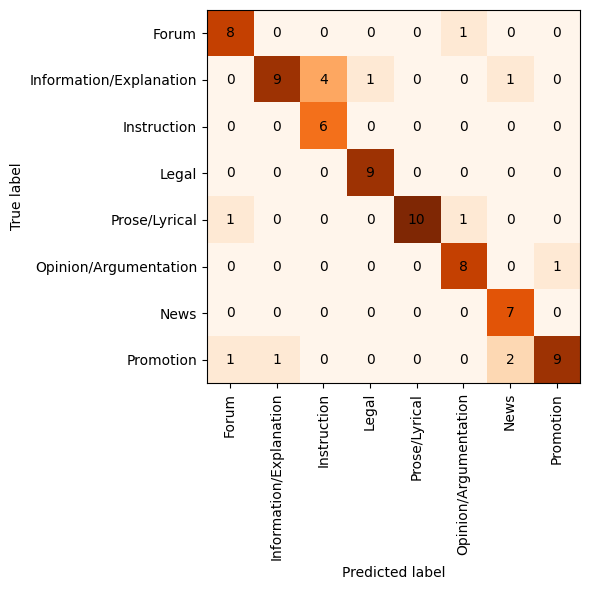

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Forum                   |      0.8    | 0.888889 |   0.842105 |     9     |
| Information/Explanation |      0.9    | 0.6      |   0.72     |    15     |
| Instruction             |      0.6    | 1        |   0.75     |     6     |
| Legal                   |      0.9    | 1        |   0.947368 |     9     |
| News                    |      0.7    | 1        |   0.823529 |     7     |
| Opinion/Argumentation   |      0.8    | 0.888889 |   0.842105 |     9     |
| Promotion               |      0.9    | 0.692308 |   0.782609 |    13     |
| Prose/Lyrical           |      1      | 0.833333 |   0.909091 |    12     |
| accuracy                |      0.825  | 0.825    |   0.825    |     0.825 |
| macro avg               |      0.825  | 0.862927 |   0.827101 |    80     |
| weighted avg            |      0.8525 | 0.825    |   0.822899 

<Figure size 640x480 with 0 Axes>

In [22]:
y_pred = df_test_clean["y_pred"].to_list()
y_true = df_test_clean["y_true"].to_list()
labels = list(df_test_clean["y_true"].unique())

results = testing(y_true, y_pred, labels)

In [23]:
# Save the final file, used for evaluation in one df which will constitute of all files

# Open the final json file
with open("/cache/tajak/macocu-mt/datasets/annotated/multilingual-genre-annotated-test-set.json", "r") as file:
	current_json = json.load(file)

# Add new language results
current_json[lang] = {"accuracy": results["accuracy"], "micro_f1": results['micro F1'], "macro_f1": results['macro F1'], "dataset": df_test_clean.to_dict()}

with open("/home/tajak/Crosslingual-Genre-Bias-Analysis/manual-annotations/multilingual-genre-annotated-test-set.json", "w") as new_file:
	json.dump(current_json, new_file, indent=2)

with open("/cache/tajak/macocu-mt/datasets/annotated/multilingual-genre-annotated-test-set.json", "w") as new_file:
	json.dump(current_json, new_file, indent=2)

In [24]:
# Open the final json file to see whether it looks fine
with open("/cache/tajak/macocu-mt/datasets/annotated/multilingual-genre-annotated-test-set.json", "r") as file:
	current_json = json.load(file)

pd.DataFrame(current_json["ca"]["dataset"])

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.ca.2248072,Opinion/Argumentation,Pàgines \n\nEnfeinada \n\nPorto uns dies una m...,Pages\n\nCoined\n\nI have been a little busy f...,{'text_id': 'macocu.ca.2248072'},Forum
1,macocu.ca.756254,Information/Explanation,Info \n\nLa Casa nova dels Banys de Sant Vicen...,Info\n\nThe Casa Nova dels Banys de Sant Vicen...,{'text_id': 'macocu.ca.756254'},Information/Explanation
2,macocu.ca.1944492,Instruction,Mousse de llimona Escola Mare de Deu de Montse...,Lemon Mousse School Mare de Deu de Montserrat ...,{'text_id': 'macocu.ca.1944492'},Instruction
3,macocu.ca.5371529,Forum,"Mourinho: Les mateixes paranoies a Anglaterra,...","Mourinho: The same paranoia in England, Italy ...",{'text_id': 'macocu.ca.5371529'},Forum
4,macocu.ca.2389428,Legal,"LLEI 15/2005, de 27 de desembre, de reforma pa...","Law 15/2005, of December 27, on partial reform...",{'text_id': 'macocu.ca.2389428'},Legal
...,...,...,...,...,...,...
79,macocu.ca.2341568,Forum,que es pot esperar? \n\ndimarts 29/abril/2008 ...,What can be expected?\n\nTuesday 29/April 2008...,{'text_id': 'macocu.ca.2341568'},Forum
80,macocu.ca.2395804,Prose/Lyrical,54 Quan aquest cos corruptible s’haurà revesti...,54 When this corruptible body has been covered...,{'text_id': 'macocu.ca.2395804'},Prose/Lyrical
82,macocu.ca.4599940,Instruction,El Kit Digital en 9 passos \n\nEl Kit Digital ...,The digital kit in 9 steps\n\nThe Digital Kit ...,{'text_id': 'macocu.ca.4599940'},Information/Explanation
83,macocu.ca.3679500,Instruction,Aquest exercici és grupal i es pot fer en dina...,This exercise is group and can be done at lunc...,{'text_id': 'macocu.ca.3679500'},Instruction


In [25]:
current_json.keys()

dict_keys(['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca'])

# Transform old csv files to json files

In [123]:
df = pd.read_csv("manual-annotations/manual-genre-evaluation-run2.tsv", sep="\t")

df.head(2)

,id,text_id,url,domain,y_pred,text,text_length,translation,y_true_run1,comment,"translation (annotation, run 2)",text_id_run2,y_true_run2,intra-annotator agreement,reasons for disagreement
0,10563,CLASSLA-web.hr.1033815,https://www.hairshop.hr/indola-professional/in...,hairshop.hr,Promotion,O proizvodu Color ...,127,"About the Color Transformer product, for smart...",Promotion,NaN,"About the product Color Transformer, for smar...","CLASSLA-web.hr.1033815', 'domain': 'hairshop.hr'}",Promotion,True,NaN
1,65197,CLASSLA-web.hr.1088566,https://www.moj-film.hr/film/info/casino-royale/,moj-film.hr,Other,Sinopsis CASINO RO...,121,Synopsis Casino Royale presents James Bond bef...,Prose/Lyrical,NaN,Synopsis Casino Royale represents James Bond ...,"CLASSLA-web.hr.1088566', 'domain': 'moj-film.hr'}",Prose/Lyrical,True,NaN


In [124]:
# Correct numerous spaces into \n symbols
df["text"] = df["text"].apply(lambda x:x.replace("                             ", "\n"))
df.text.to_list()[:2]

['O proizvodu\nColor Transformer, za pametno i jednostavno bojanje . Učinite nemoguće mogućim!!\nColour Transformer pretvara bilo koju Indola permanentnu nijansu* u demi permanentnu nijansu.\nNova formula, izuzetno jednostavna za upotrebu 1: 1 s permanentnom nijansom\nSamo jednu linija boja uz povećanje svog asortiman nijansi\nNježna formula za podršku zdravoj, sjajnoj kosi\nColor Transformer tehnologija pretvara permanentne nijanse u demi-permanentne, omogućavajući jedinstvenom i dobro uravnoteženom sustavu da postigne klasične demi-permanentne uvjete boja u jednostavnoj, sigurnoj i prikladnoj primjeni. Rezultat boja je besprijekoran, od korijena do vrhova, sjajanog i zdravog izgleda.\nOsigurajte rezultate sjajne boje zdravog izgleda zahvaljujući nježnijoj usluzi bojenja pomoću COLOR TRANSFORMERA, a istovremeno osigurava savršeno podudaranje boja.\nNije potrebno imati dodatne demi-permanentne boje niti imati posebnu policu u svom salonu.\nOmjer miješanja: 1:1. Miješajte PCC nijansu s 

In [125]:
# Add information on lang suffix
df["lang"] = df["text_id"].apply(lambda x:x[12:14])

df.lang.value_counts()

lang
hr    90
mk    90
sl    90
Name: count, dtype: int64

In [126]:
lang = "mk"

In [127]:
# Filter out texts that are from one corpus based on lang suffix
df = df[df["lang"] == lang]

df.describe(include="all")

,id,text_id,url,domain,y_pred,text,text_length,translation,y_true_run1,comment,"translation (annotation, run 2)",text_id_run2,y_true_run2,intra-annotator agreement,reasons for disagreement,lang
count,90.000000,90,90,90,90,90,90.000000,90,90,14,90,90,90,90,9,90
unique,NaN,90,90,63,9,90,NaN,90,10,7,90,90,10,2,4,1
top,NaN,CLASSLA-web.mk.1000486,"http://forum.carclub.mk/index.php/topic,1900.1...",forum.carclub.mk,Forum,"Екшули, TCL ги прави смартфоновите, а TCL е см...",NaN,"Ekshui, TCL makes smartphones, and TCL is hous...",Opinion/Argumentation,Not a coherent text,"Ekshui, TCL makes smartphones, and TCL is hous...","CLASSLA-web.mk.1000486', 'domain': 'forum.carc...",Promotion,True,disagreement,mk
freq,NaN,1,1,5,10,1,NaN,1,15,7,1,1,12,75,5,90
mean,53941.466667,NaN,NaN,NaN,NaN,NaN,230.355556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,28369.079914,NaN,NaN,NaN,NaN,NaN,113.578989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,403.000000,NaN,NaN,NaN,NaN,NaN,86.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,29277.000000,NaN,NaN,NaN,NaN,NaN,134.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,59665.500000,NaN,NaN,NaN,NaN,NaN,200.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,78735.000000,NaN,NaN,NaN,NaN,NaN,311.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# Discard unnecessary columns
df = df[["text_id", "y_pred", "text", "translation", "text_id_run2","y_true_run2"]]

# Rename columns
df.columns = [["text_id", "y_pred", "text", "translation", "metadata","y_true"]]

df.head(3)

,text_id,y_pred,text,translation,metadata,y_true
90,CLASSLA-web.mk.1000486,Forum,"Екшули, TCL ги прави смартфоновите, а TCL е см...","Ekshui, TCL makes smartphones, and TCL is hous...","CLASSLA-web.mk.1000486', 'domain': 'forum.carc...",Forum
91,CLASSLA-web.mk.1009071,News,Red Valentino прогнозира бура од принтови за с...,Red Valentino predicts a storm of prints for n...,"CLASSLA-web.mk.1009071', 'domain': 'fashionel....",News
92,CLASSLA-web.mk.1043814,Instruction,Најголем фактор на ризик за развој на проширен...,The biggest risk factor for the development of...,"CLASSLA-web.mk.1043814', 'domain': 'puls24.mk'}",Instruction


In [129]:
# Flatten the MultiIndex columns
df.columns = ['_'.join(col).strip() for col in df.columns]
df.columns

Index(['text_id', 'y_pred', 'text', 'translation', 'metadata', 'y_true'], dtype='object')

In [130]:
# Save the corpus to cache and crosslingual repository
df.to_json(f"/cache/tajak/macocu-mt/datasets/manually-evaluated/MaCoCu-{lang}-genre-sample-evaluated.jsonl", orient="records", lines=True)

df.to_json(f"/home/tajak/Crosslingual-Genre-Bias-Analysis/manual-annotations/MaCoCu-{lang}-genre-sample-evaluated.jsonl", orient="records", lines=True)

# Add Dummy results

In [6]:
from sklearn.dummy import DummyClassifier

In [20]:
# Import the dataset on which the X-GENRE classifier was trained
from datasets import load_dataset

train = load_dataset("TajaKuzman/X-GENRE-multilingual-text-genre-dataset", "train")

train_df = pd.DataFrame(train["train"])

train_df.head()

,text,labels,dataset,language
0,"Seeking All Things Brilliant ""I want people to...",Other,CORE,English
1,Meet Orchid du Bois I first met Hayley Mowday ...,Other,CORE,English
2,Abstract Objective: Reporting bias due to soci...,Information/Explanation,CORE,English
3,In 2009 the song was the focus of a successful...,Information/Explanation,CORE,English
4,QuotW This was the week when neither rumours o...,News,CORE,English


In [21]:
df_test_clean.head()

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},News
1,macocu.mt.377203,Prose/Lyrical,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},Opinion/Argumentation
2,macocu.mt.109995,Forum,Chrysler: Brand ta 'lussu jew le? \n\nBrand ji...,Chrysler: Luxury brand or not?\n\nBrand moves ...,{'text_id': 'macocu.mt.109995'},Opinion/Argumentation
3,macocu.mt.243402,Forum,Kif tkellem lit-tfal dwar id-diżabbiltajiet \n...,How to talk to children about disabilities\n\n...,{'text_id': 'macocu.mt.243402'},Instruction
4,macocu.mt.213859,Forum,Kif tneħħi hangover sewwa u bla perikolu \n\nH...,How to remove a proper and safe hangover\n\nHa...,{'text_id': 'macocu.mt.213859'},Instruction


In [24]:
# Create X_train and Y_train parts, used for sci kit learning
# We need to split each split (test and train) into an object with just texts and object with just labels. Test df is df_test_clean
X_train = list(train_df.text)
Y_train = list(train_df.labels)

X_test = list(df_test_clean.text)
Y_test = list(df_test_clean["y_pred"])

# See their sizes
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1772, 1772, 78, 78)

## Most-frequent dummy

Macro f1: 0.0403, Micro f1: 0.192
Accuracy: 0.192


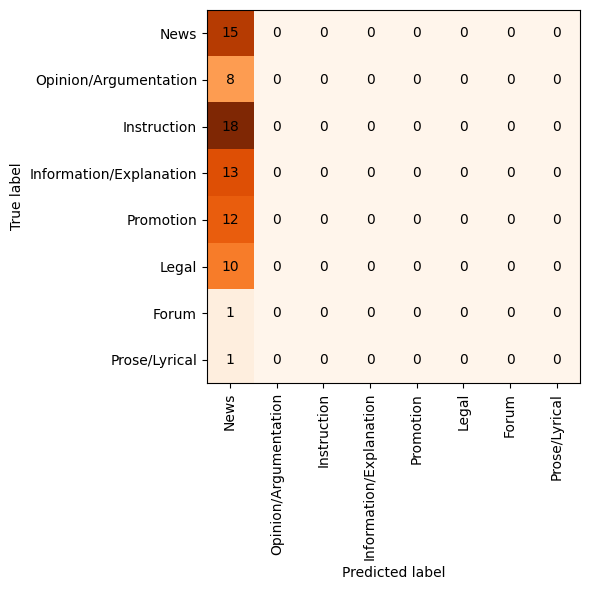

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Forum                   |   0         | 0        |  0         |  1        |
| Information/Explanation |   0         | 0        |  0         | 13        |
| Instruction             |   0         | 0        |  0         | 18        |
| Legal                   |   0         | 0        |  0         | 10        |
| News                    |   0.192308  | 1        |  0.322581  | 15        |
| Opinion/Argumentation   |   0         | 0        |  0         |  8        |
| Promotion               |   0         | 0        |  0         | 12        |
| Prose/Lyrical           |   0         | 0        |  0         |  1        |
| accuracy                |   0.192308  | 0.192308 |  0.192308  |  0.192308 |
| macro avg               |   0.0240385 | 0.125    |  0.0403226 | 78        |
| weighted avg            |   0.0369822 | 0.192308 |  0.0620347 

/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

<Figure size 640x480 with 0 Axes>

In [29]:
# Use the Dummy Classifier, with the strategy "most_frequent"
dummy_mf = DummyClassifier(strategy="most_frequent")

# Train the model
dummy_mf.fit(X_train, Y_train)

#Get the predictions
y_pred_mf = dummy_mf.predict(X_test)

# Evaluate the predictions
y_pred = list(y_pred_mf)
y_true = df_test_clean["y_true"].to_list()
labels = list(df_test_clean["y_true"].unique())

results = testing(y_true, y_pred, labels)

## Stratified dummy

Macro f1: 0.105, Micro f1: 0.131
Accuracy: 0.128


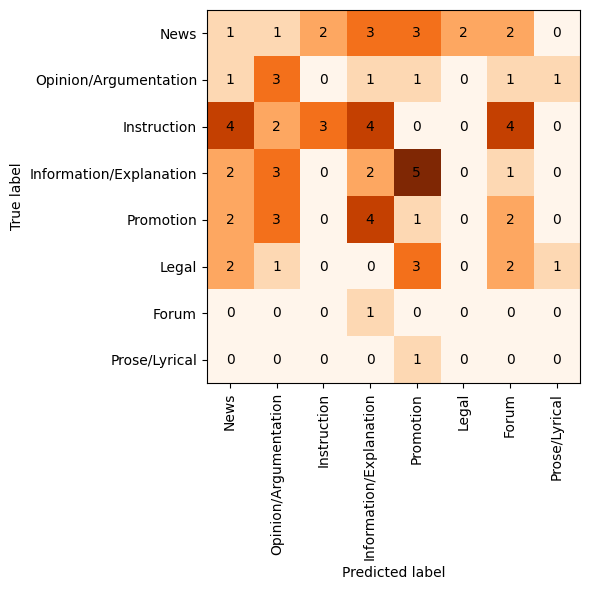

|                         |   precision |    recall |   f1-score |   support |
|:------------------------|------------:|----------:|-----------:|----------:|
| Forum                   |   0         | 0         |  0         |  1        |
| Information/Explanation |   0.133333  | 0.153846  |  0.142857  | 13        |
| Instruction             |   0.6       | 0.166667  |  0.26087   | 18        |
| Legal                   |   0         | 0         |  0         | 10        |
| News                    |   0.0833333 | 0.0666667 |  0.0740741 | 15        |
| Opinion/Argumentation   |   0.230769  | 0.375     |  0.285714  |  8        |
| Other                   |   0         | 0         |  0         |  0        |
| Promotion               |   0.0714286 | 0.0833333 |  0.0769231 | 12        |
| Prose/Lyrical           |   0         | 0         |  0         |  1        |
| accuracy                |   0.128205  | 0.128205  |  0.128205  |  0.128205 |
| macro avg               |   0.124318  | 0.0939459 

/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 

<Figure size 640x480 with 0 Axes>

In [30]:
# Use the Dummy Classifier, with the strategy "most_frequent"
dummy_s = DummyClassifier(strategy="stratified")

# Train the model
dummy_s.fit(X_train, Y_train)

#Get the predictions
y_pred_s = dummy_s.predict(X_test)

# Evaluate the predictions
y_pred = list(y_pred_s)
y_true = df_test_clean["y_true"].to_list()
labels = list(df_test_clean["y_true"].unique())

results = testing(y_true, y_pred, labels)